# Recommender systems in streaming environment

In [1]:
import matplotlib as mpl 
mpl.use("pgf") 
pgf_with_rc_fonts = {
    "font.serif": [],
}

import numpy as np
import pandas as pd
import random

%matplotlib inline
import matplotlib.pyplot as plt

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams["axes.facecolor"] = 'w'

### Load MovieLens 1M rating dataset

(positive only)

In [2]:
ratings = []
with open('../../data/ml-1m/ratings.dat') as f:
    lines = map(lambda l: map(int, l.rstrip().split('::')), f.readlines())
    for l in lines:
        # Since we consider positive-only feedback setting, ratings < 5 will be excluded.
        if l[2] == 5: ratings.append(l)

ratings = np.asarray(ratings)
ratings.shape

(226310, 4)

In [3]:
# sorted by timestamp
ratings = ratings[np.argsort(ratings[:, 3])]
ratings[:5]

array([[     6040,       593,         5, 956703954],
       [     6040,      2019,         5, 956703977],
       [     6040,      3111,         5, 956704056],
       [     6040,       213,         5, 956704056],
       [     6040,       912,         5, 956704191]])

In [4]:
n_ratings = ratings.shape[0]
n_train = int(n_ratings * 0.2)
n_ratings, n_train, n_ratings-n_train

(226310, 45262, 181048)

In [5]:
users = set([])
items = set([])
for u, i, r, t in ratings:
    users.add(u)
    items.add(i)
users = list(users)
items = list(items)

n_user = len(users)
n_item = len(items)

n_user, n_item

(6014, 3232)

### Prepare

In [6]:
window_size = 5000 # for SMA
N = 10 # recall@10

window_size, N

(5000, 10)

In [7]:
%load_ext autoreload
%autoreload 2

from incremental_MF import IncrementalMF
from incremental_biasedMF import IncrementalBiasedMF

In [8]:
def plot_setting(fig, ax):
    ax.set_xlabel('index', fontsize=11)
    ax.set_ylabel('recall@10', fontsize=11)
    ax.yaxis.grid(True)
    ax.set_xticks([0, 50000, 100000, 150000])
    ax.set_yticks([0.00, 0.025, 0.05, 0.075, 0.10])
    ax.set_xlim([-5000.0, 180000])
    ax.set_ylim([0.0, 0.10])
    ax.axvline(x=window_size, linewidth=1, linestyle='--', color='gray')
    fig.set_size_inches((5.5,3))
    fig.patch.set_alpha(0.0)

## Evaluation methodology

Following paper describes how we can evaluate recommender systems in streaming environments.

J. Vinagre, et al., "**Evaluation of Recommender Systems in Streaming Environments**," Proc. of REDD 2014, Oct. 2014.

The key idea is a *test-then-learn* procedure. To give an example, for the Movielens-1M dataset, the authors set the following evaluation procedure with positive-only setting (i.e. use only positive "5" ratings):

1. Initialize a model with the first 20% events.
2. Observe an evant *(user, item, rating)* one-by-one.
    - If *user* is already known:
        - generate recommendation list and check if *item* is in the list (i.e. compute **recall@10**).
        - compute Simple Moving Average (SMA) of **recall@10** for the most recent $n=5000$ events.
3. Update the model based on the observed event, and proceed 2.

### Baseline

train 20% and use the model for all new observations

In [9]:
# initialize
imf = IncrementalMF(n_user, n_item, k=100, l2_reg=0.01, learn_rate=0.03)
history_mat = np.zeros((n_user, n_item))
base_avgs, sma = [], []

In [10]:
%%time

# to avoid cold-start, train initial 20% samples
for ri in xrange(n_train):
    u, i, rating, timestamp = ratings[ri]
    u_index = users.index(u)
    i_index = items.index(i)
    imf.update(u_index, i_index)
    history_mat[u_index, i_index] = 1

CPU times: user 11.2 s, sys: 97.4 ms, total: 11.3 s
Wall time: 11.4 s


In [11]:
%%time

# start stream recommendation
for ri in xrange(n_train, n_ratings):
    u, i, rating, timestamp = ratings[ri]
    u_index = users.index(u)
    i_index = items.index(i)
    
    # 1.
    if u_index in imf.known_users:
        # If u is a known user, use the current model to recommend N items,
        recos = imf.recommend(u_index, N, history_mat[u_index])
        
        # 2. Score the recommendation list given the true observed item i
        recall = 1 if (i_index in recos) else 0
        
        sma.append(recall)
        n = len(sma)
        if n > window_size: 
            del sma[0]
            n -= 1
        avg = sum(sma) / float(n)
        base_avgs.append(avg)
    
    # 3. update the know_users and known_items list (w/o updating the model)
    if u_index not in imf.known_users: imf.known_users = np.append(imf.known_users, u_index)
    if i_index not in imf.known_items: imf.known_items = np.append(imf.known_items, i_index)

    history_mat[u_index, i_index] = 1

CPU times: user 2min 15s, sys: 7.15 s, total: 2min 22s
Wall time: 2min 13s


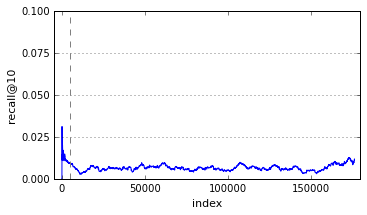

In [12]:
fig, ax = plt.subplots()
ax.plot(range(len(base_avgs)), base_avgs)
plot_setting(fig, ax)

### Incremental Matrix Factorization (iMF)

- Run a test-then-learn procedure
- Simple Moving Average (SMA) with window size $n=5000$

In [13]:
# initialize
imf = IncrementalMF(n_user, n_item, k=100, l2_reg=0.01, learn_rate=0.03)
history_mat = np.zeros((n_user, n_item))
imf_avgs, sma = [], []

In [14]:
%%time

# to avoid cold-start, train initial 20% samples
for ri in xrange(n_train):
    u, i, rating, timestamp = ratings[ri]
    u_index = users.index(u)
    i_index = items.index(i)
    imf.update(u_index, i_index)
    history_mat[u_index, i_index] = 1

CPU times: user 10.9 s, sys: 67.2 ms, total: 11 s
Wall time: 11 s


In [15]:
%%time

# start stream recommendation
for ri in xrange(n_train, n_ratings):
    u, i, rating, timestamp = ratings[ri]
    u_index = users.index(u)
    i_index = items.index(i)
    
    # 1.
    if u_index in imf.known_users:
        # If u is a known user, use the current model to recommend N items,
        recos = imf.recommend(u_index, N, history_mat[u_index])
        
        # 2. Score the recommendation list given the true observed item i
        recall = 1 if (i_index in recos) else 0
        
        sma.append(recall)
        n = len(sma)
        if n > window_size: 
            del sma[0]
            n -= 1
        avg = sum(sma) / float(n)
        imf_avgs.append(avg)
    
    # 3. update the model with the observed event
    imf.update(u_index, i_index)
    
    history_mat[u_index, i_index] = 1

CPU times: user 2min 2s, sys: 6.07 s, total: 2min 8s
Wall time: 1min 58s


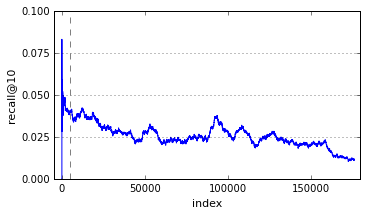

In [16]:
fig, ax = plt.subplots()
ax.plot(range(len(imf_avgs)), imf_avgs)
plot_setting(fig, ax)

### Incremental Biased Matrix Factorization (Biased-iMF)

As one specific case of Factorization Machines.

Regularization parameters for the bias terms are updated adaptively.

In [17]:
# initialize
ibmf = IncrementalBiasedMF(n_user, n_item, k=100, l2_reg_w0=.01, l2_reg_w=.01, l2_reg_V=.01, learn_rate=.03)
history_mat = np.zeros((n_user, n_item))
ibmf_avgs, sma = [], []

In [18]:
%%time

prev_w0 = prev_w = None

# to avoid cold-start, train initial 20% samples
for ri in xrange(n_train):
    u, i, rating, timestamp = ratings[ri]
    u_index = users.index(u)
    i_index = items.index(i)
    prev_w0, prev_w = ibmf.update(u_index, i_index, prev_w0, prev_w)
    history_mat[u_index, i_index] = 1

CPU times: user 11.6 s, sys: 107 ms, total: 11.7 s
Wall time: 11.8 s


incremental_biasedMF.py:48: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if prev_w0 != None and prev_w != None:


In [19]:
%%time

for ri in xrange(n_train, n_ratings):
    u, i, rating, timestamp = ratings[ri]
    u_index = users.index(u)
    i_index = items.index(i)
    
    # 1.
    if u_index in ibmf.known_users:
        # If u is a known user, use the current model to recommend N items,
        recos = ibmf.recommend(u_index, N, history_mat[u_index])
        
        # 2. Score the recommendation list given the true observed item i
        recall = 1 if (i_index in recos) else 0
        
        sma.append(recall)
        n = len(sma)
        if n > window_size: 
            del sma[0]
            n -= 1
        avg = sum(sma) / float(n)
        ibmf_avgs.append(avg)
    
    # 3. update the model with the observed event
    prev_w0, prev_w = ibmf.update(u_index, i_index, prev_w0, prev_w)
    history_mat[u_index, i_index] = 1

CPU times: user 2min 19s, sys: 7 s, total: 2min 26s
Wall time: 2min 14s


### Compare the result

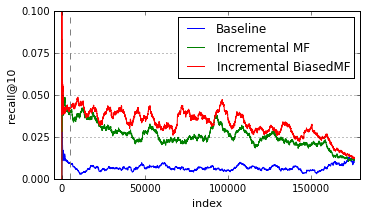

In [21]:
fig, ax = plt.subplots()
ax.plot(range(len(base_avgs)), base_avgs, label='Baseline')
ax.plot(range(len(imf_avgs)), imf_avgs, label='Incremental MF')
ax.plot(range(len(ibmf_avgs)), ibmf_avgs, label='Incremental BiasedMF')
ax.legend()
plot_setting(fig, ax)

fig.savefig('../../paper/images/ml-1m-recall-evolve.pdf')